In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import itertools
import serie2GAF
import pickle
import learn_utils
import meta_features as mf
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from detect_peaks import detect_peaks
from gaussian_kde import gaussian_kde
from sklearn.neighbors import KernelDensity
from operator import itemgetter
from sklearn.externals import joblib
from time import time

import scipy.signal as signal
import matplotlib.pyplot as plt

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Data description

The features selected for this dataset come from the accelerometer and gyroscope 3-axial raw signals tAcc-XYZ and tGyro-XYZ. That signal was taken using the <a href=http://playground.arduino.cc/Main/MPU-6050> InvenSense MPU-6050 </a> sensor, which contains a MEMS accelerometer and a MEMS gyro in a single chip. The sensor possess a 16-bits analog to digital conversion hardware for each channel. Therefor it captures the x, y, and z channel at the same time. The sensor was used with the I2C-bus to interface with an Arduino attached to the player.  We also use a Microsoft Kinect 2 sensor in order to get 3 additional features: Contraction Index (CI), distance, proximity. This last feature is a normalized - [0,1] interval - version of distance. Thus, they shall be used in mutually exclusion. The normalization is done by limiting the distance to 4.5 meters, the known stable limit of the sensor. So, the player has a greater proximity value when it is seen close to the robot. The value tends to zero otherwise. Ideally, the CI feature correspond to how open-wide (in terms of legs and arms) the player is.

## Support functions

WARNING: If "too many valus to unpack" error in the getCSV method, restart the kernel. Something must bust be wrong with the kernel initialization. Must be checked (LOW-PRIORITY).

### Load

In [2]:
def loadFile(file_name, directory, ignore_col_list = ['/ext_usb_camera/image/compressed', 'robogame/imu_state'],
             verbose=False):
    
    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    #print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(directory, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    #print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

### Filtering

In [3]:
def runningMean(l, N):
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)

    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])

def computeRunMeanAcc(data, showPlot= False, suptitle="Running average smoothing", feature='activity', N=4):
    """Running average as smoothing"""
    

    ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
    # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
    norm_dataX = running_mean(data, N)
    
    if showPlot:
        fig, ax = plt.subplots(1,1, figsize=(18,8))
        N_samps = len(norm_dataX)
        Fs = N_samps/time_interval
        print "Time interval: ", str(time_interval)
        # the period represents the oscilation. It's  the sample time, the time after which each data come.
        T = 1./Fs
        print "Period: {}".format(T)

        t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

        ax.set_ylabel('g\'s (9.8 m/s^2)')
        ax.plot(norm_dataX)
        ax.grid()
        #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)

        plt.draw()
    
    return norm_dataX

In [4]:
def moving_rmsV1(x, window):
    """Moving RMS of 'x' with window size 'window'."""
    window = 2*window + 1
    return np.sqrt(np.convolve(x*x, np.ones(window)/window, 'same'))

### Processing

In [5]:
def processFiles(listOfFiles, directory, plot_signal=False):
    failed_files = []
    
    acc_frequences = []
    ciprox_frequences = []
    datasetX = []
    datasetY = []
    datasetZ = []
    datasetCI = []
    datasetProximity = []

    for f in listOfFiles:
        csv_filename = f
        file_data = []             # the list of windows data. Each element is a pandas dataframe 
                                   #  corresponding to the windows. The list is of size 'num_windows'.

        #print 'Processing: "{}"'.format(csv_filename)

        # load the data, abort in case of error.
        try:
            file_data = loadFile(csv_filename, directory)
        except ValueError as e:
            #print traceback.format_exc()
            failed_files.append(csv_filename)
            continue

        #### Normalize to g's accelerometer axis ####
        allAccX = []
        allAccY = []
        allAccZ = []
        allCi   = []
        allProximity = []
        time_interval = 0
        
        #print '-- Normalizing accelerometer data...'
        for i, w in enumerate(file_data):
            if i==0:
                time_interval = w['time'].iloc[-1]
                for x, y, z in zip(w['accX'].dropna().as_matrix(),
                                   w['accY'].dropna().as_matrix(),
                                   w['accZ'].dropna().as_matrix()):
                    
                    allAccX.append(x/16384.0)
                    allAccY.append(y/16384.0)
                    allAccZ.append(z/16384.0)
                
                for c, p in zip(w['ci'].dropna().as_matrix(),
                                w['proximity'].dropna().as_matrix()):
                    if c > 1:
                        allCi.append(1)
                    else:
                        allCi.append(c)
                    if p > 1:
                        allProximity.append(1)
                    else:
                        allProximity.append(p)
                    
            else:
                values = list(set(w['time']) - set(file_data[i-1]['time']))
                time_interval = w['time'].iloc[-1]
                result = w[w['time'].isin(values)]
                for x, y, z in zip(result['accX'].dropna().as_matrix(),
                                   result['accY'].dropna().as_matrix(),
                                   result['accZ'].dropna().as_matrix()):
                    
                    allAccX.append(x/16384.0)
                    allAccY.append(y/16384.0)
                    allAccZ.append(z/16384.0)
                
                for c, p in zip(w['ci'].dropna().as_matrix(),
                                w['proximity'].dropna().as_matrix()):   
                    if c > 1:
                        allCi.append(1)
                    else:
                        allCi.append(c)
                    if p > 1:
                        allProximity.append(1)
                    else:
                        allProximity.append(p)
        
        ## Acc Frequency
        N_samps = len(allAccX)
        Fs = N_samps/time_interval
        acc_frequences.append((Fs, csv_filename))
        
        ## CI/PROX Frequency
        ci_n_samps = len(allCi)
        ciproxFs = ci_n_samps/time_interval
        ciprox_frequences.append((ciproxFs,csv_filename))

        if plot_signal:
            print "-- Time interval: ", str(time_interval)
            ## the period represents the oscilation. It's  the sample time, the time after which each data come.
            T = 1./Fs
            t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.
            fig, ax = plt.subplots(1,1, figsize=(18,8))
            ax.plot(t,dataX_Scaled, c='g', label='Scaled')
            ax.plot(t,dataX_AC, c='r', label='AC')
            ax.plot(t,dataX_filtered, c='m', label='Filtered')
            ax.plot(t,allAccX, c='b', label='Original')
            ax.plot(t,norm_dataZ, c='r', label='Z')
            ax.set_ylabel("g's")
            ax.set_ylim(0,0.05)
            ax.set_xlabel('Time (secs)')
            plt.title(csv_filename)
            plt.legend()
            #plt.yscale('log')
            plt.draw()

        datasetX.append((list(allAccX),csv_filename))
        datasetY.append((list(allAccY),csv_filename))
        datasetZ.append((list(allAccZ),csv_filename))
        datasetCI.append((list(moving_rmsV1(np.array(allCi), 15)),csv_filename))
        datasetProximity.append((list(moving_rmsV1(np.array(allProximity), 15)),csv_filename))
        
    return (datasetX, datasetY, datasetZ, datasetCI, datasetProximity, acc_frequences, ciprox_frequences)

## Plotting

In [6]:
def gridPlotting(data, suptitle="Segments", plt_win_func=False, labels="", set_axis_off=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size)

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                row[j].set_title("W={}".format(count), fontsize=8, fontweight="bold")
                row[j].plot(data[count], label=labels)
                row[j].grid()
                
                if set_axis_off:
                    row[j].set_xticks(())
                    row[j].set_yticks(())
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    #fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.draw()

def gridGAFPlotting(data, suptitle="GAF Segments", plt_win_func=False, labels=""):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size)

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                if data[count] == []:
                    print "WARN: Windows #{} is empty!".format(count)
                    
                row[j].set_xticks(())
                row[j].set_yticks(())
                row[j].set_title("W={}".format(count), fontsize=8, fontweight="bold")
                row[j].imshow(data[count])
                count += 1
                
    #fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.draw()
    
def plot_images(n_rows, n_cols, images):
    f = plt.figure()
    for i, image in enumerate(images):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

def plot_colormap(matrix, cmap_fmt= "jet", normalize = True, title='topic proportions', xlabel='topics',
    ylabel='documents'):
    
    plt.matshow(matrix, cmap=plt.get_cmap(cmap_fmt))
    plt.gca().set_aspect('auto')
    plt.title(title)
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "magenta")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(cax = cax)
    plt.show()

___

## BEGGINING EXPERIMENTS

### Load CSV files

In [7]:
csv_dir = "../data/annotated_csv/"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-26-17-15-53_fixed_exp1d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-26-17-15-53_fixed_exp2d_Player.csv", "_2016-11-26-18-36-15_expa_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-26-16-35-21_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-26-18-36-15_expb_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-26-17-15-53_exp4_Player.csv", "_2016-11-26-16-49-44_exp1d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-17-15-38_expb_Pla

In [8]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [9]:
def getSegments(df, data_type, windows_size=50, win_overlap=5, plot=True, HzTresh=45):
    '''## Extracts the time series segments
    df: the pandas data frame having the data.
    data_type: ['cipr' | 'acc'] the type of data we want to extract segments from.
    windows_size: Number of samples per windows.
    win_overlap: the overlap between the windows.
    plot: whether to plot the time series for visual inspection.
    '''
    
    font = {'family': 'serif',
        'color':  'green',
        'weight': 'normal',
        'size': 11,
        }
    
    ### windowing function
    window_rads = np.linspace(0, np.pi, windows_size)
    window = np.sin(window_rads)**2
    # plt.plot(window)
    # plt.show()
    x_segment_list = []
    y_segment_list = []
    z_segment_list = []
    ci_segment_list = []
    pr_segment_list = []
    
    for i in range(df.shape[0]):
        f_number = i
        
        if df['accFrq'][f_number] < HzTresh:
            print "Skipping low-hz acc file"
            continue
        
        x_segments = []
        y_segments = []
        z_segments = []
        ci_segments= []
        pr_segments= []
        
        #for i in range(df.shape[0]):
        x = df['x'].tolist()[f_number]
        y = df['y'].tolist()[f_number]
        z = df['z'].tolist()[f_number]
        
        ci      = df['ci'].tolist()[f_number]
        prox    = df['proximity'].tolist()[f_number]
        filecsv = df['file'].tolist()[f_number]
        
        # make a copy so changes to 'segments' doesn't modify the original
        if data_type == 'acc':
            for start_pos in range(0, len(x), windows_size):
                end_pos = start_pos + windows_size
                
                x_segment = np.copy(x[start_pos:end_pos])
                y_segment = np.copy(y[start_pos:end_pos])
                z_segment = np.copy(z[start_pos:end_pos])
                
                # if we're at the end and we've got a truncated segment, drop it
                if len(x_segment) != windows_size:
                    continue
                
                x_segments.append(x_segment)     
                y_segments.append(y_segment)
                z_segments.append(z_segment)
                
            print "{} file produced {} waveform segments".format(filecsv, len(x_segments))
            
        elif data_type == 'cipr':
            for start_pos in range(0, len(ci), windows_size):
                end_pos = start_pos + windows_size
                ci_segment = np.copy(ci[start_pos:end_pos])
                pr_segment = np.copy(prox[start_pos:end_pos])
                # if we're at the end and we've got a truncated segment, drop it

                if len(ci_segment) != windows_size:
                    continue

                ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
                # x_segment = x_segment * window
                # y_segment = y_segment * window
                # z_segment = z_segment * window
                # ci_segment= ci_segment * window
                # pr_segment= pr_segment * window

                ci_segments.append(ci_segment)
                pr_segments.append(pr_segment)
                
            print "{} file produced {} waveform segments".format(filecsv, len(ci_segments))
            
        # persisting segments on the segment list
        x_segment_list.append(x_segments)
        y_segment_list.append(y_segments)
        z_segment_list.append(z_segments)
        ci_segment_list.append(ci_segments)
        pr_segment_list.append(pr_segments)
  
        if plot:

            # getting acc timeline
            accFs          =  df['accFrq'][f_number]
            N_samps        = len(x)
            acc_timeline   = np.linspace(0,N_samps*(1/accFs),N_samps) # N_samps*T (#samples x sample period)
                                                                     # is the signal time.

            # getting ci/proximity timeline
            cpFs           =  df['ciprFrq'][f_number]
            N_samps_ciprox = len(ci)
            cipr_timeline   = np.linspace(0,N_samps_ciprox*(1/cpFs),N_samps_ciprox) # N_samps*T (#samples x sample period) 
                                                                     # is the signal time.

            fig = plt.figure(figsize=[12,7])
            plt.suptitle("ID={} -- File={}, Acc_Hz={:.2f}, CI/PR_Hz={:.2f}".format(f_number,filecsv,
                                                                  df['accFrq'][f_number],
                                                                  df['ciprFrq'][f_number]))
            ax0 = plt.subplot(411)
            ax0.plot(acc_timeline,x, label='x')
            ax0.plot(acc_timeline,y, label='y')
            ax0.plot(acc_timeline,z, label='z')

            plt.grid()
            plt.legend(loc='best', frameon=False, fontsize=8)
            ax1 = plt.subplot(412, sharex=ax0)
            ax1.plot(cipr_timeline, ci, label='ci')
            ax1.plot(cipr_timeline, prox, label='prox')
            plt.grid()
            plt.legend(loc='best', frameon=False, fontsize=8)

            plt.draw()

    return x_segment_list, y_segment_list, z_segment_list, ci_segment_list, pr_segment_list

In [10]:
datasetX, datasetY, datasetZ, datasetCI, datasetProximity, accfreq, ciprFrq = processFiles(files,csv_dir)

In [11]:
dic = {'x'   :[x[0] for x in datasetX],
       'y'   :[y[0] for y in datasetY],
       'z'   :[z[0] for z in datasetZ],
       'ci'   :[c[0] for c in datasetCI],
       'proximity' :[p[0] for p in datasetProximity],
       'accFrq': [acc[0] for acc in accfreq],
       'ciprFrq': [ci[0] for ci in ciprFrq],
       'file': [f[1] for f in datasetX]} 
arm_df = pd.DataFrame(dic, columns=['x','y','z','ci','proximity', 'accFrq','ciprFrq','file'])

print "Median of accelerometer frequency: {:.2f}Hz".format(np.median(arm_df['accFrq']))
print "Median of ci/pr frequency: {:.2f}Hz".format(np.median(arm_df['ciprFrq']))

Median of accelerometer frequency: 48.88Hz
Median of ci/pr frequency: 28.52Hz


### Segment size

In [12]:
win_size = 32
print "~Time of segment: {:.2}secs".format(win_size * (1/np.median(arm_df['accFrq'])))

~Time of segment: 0.65secs


_2016-11-24-16-48-48_exp3d_Player.csv file produced 57 waveform segments
_2016-11-24-16-48-48_exp1d_Player.csv file produced 107 waveform segments
_2016-11-24-16-23-29_expb_Player.csv file produced 61 waveform segments
_2016-11-26-17-15-53_fixed_exp2d_Player.csv file produced 59 waveform segments
_2016-11-26-18-36-15_expa_Player.csv file produced 45 waveform segments
_2016-11-23-18-49-13_exp2_Player.csv file produced 66 waveform segments
_2016-11-24-16-23-29_expa_Player.csv file produced 39 waveform segments
_2016-11-23-18-49-13_exp4_Player.csv file produced 54 waveform segments
_2016-11-26-16-05-47_exp1d_Player.csv file produced 107 waveform segments
_2016-11-24-15-43-37_exp1d_Player.csv file produced 73 waveform segments
_2016-11-23-18-49-13_exp5_Player.csv file produced 64 waveform segments
_2016-11-26-16-35-21_exp1d_Player.csv file produced 142 waveform segments
_2016-11-26-18-36-15_expb_Player.csv file produced 167 waveform segments
_2016-11-24-17-40-06_expb_Player.csv file produc

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


_2016-11-26-17-15-53_exp2_Player.csv file produced 75 waveform segments
_2016-11-23-18-49-13_exp1_Player.csv file produced 57 waveform segments
Skipping low-hz acc file
_2016-11-24-15-43-37_exp2d_Player.csv file produced 111 waveform segments
_2016-11-26-17-15-53_exp3_Player.csv file produced 66 waveform segments
_2016-11-26-17-38-21_fixed_exp1d_Player.csv file produced 104 waveform segments


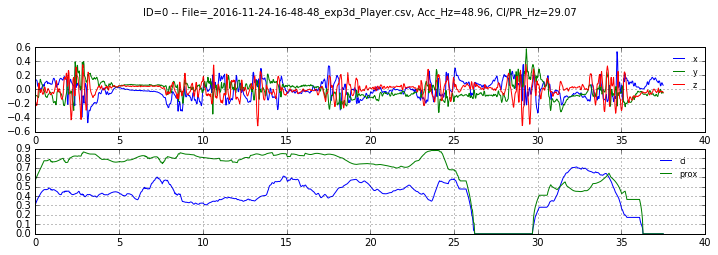

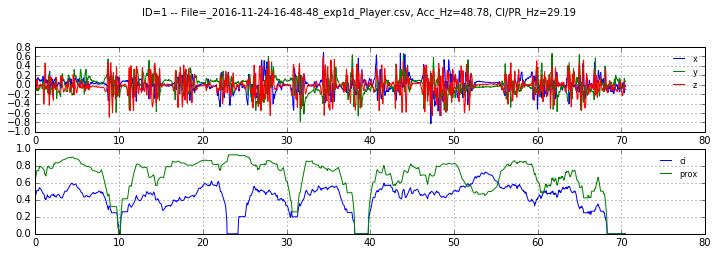

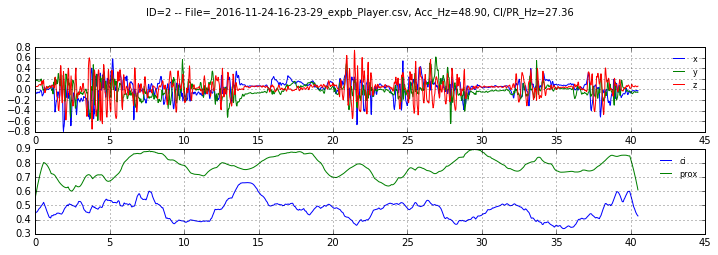

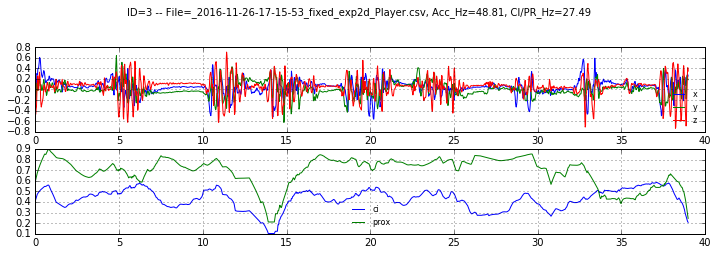

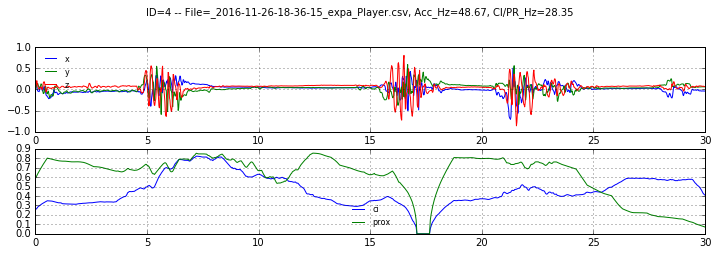

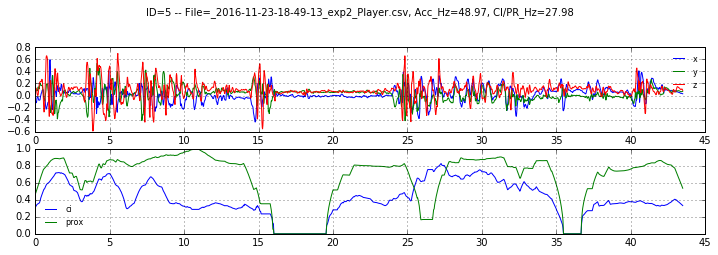

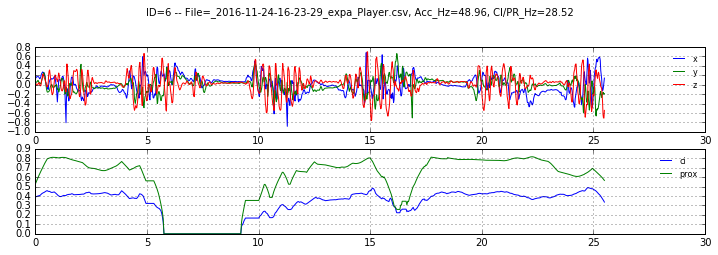

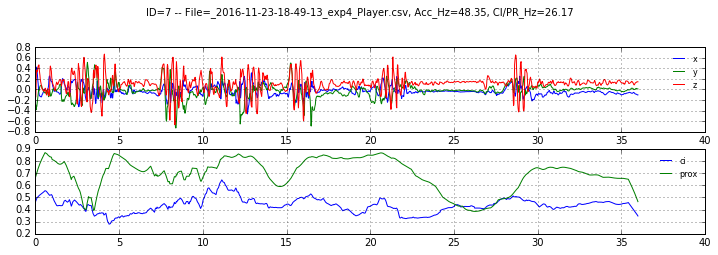

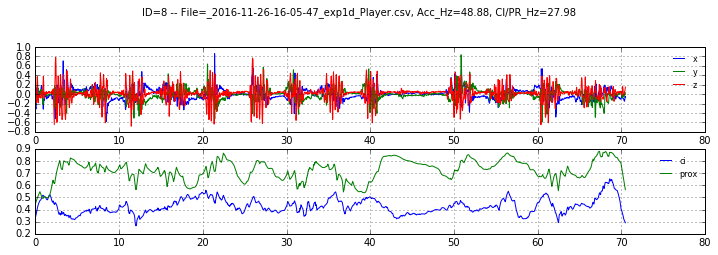

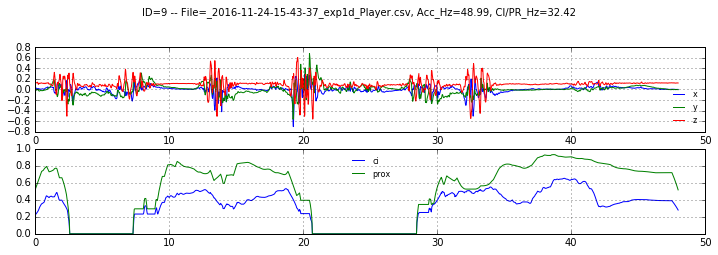

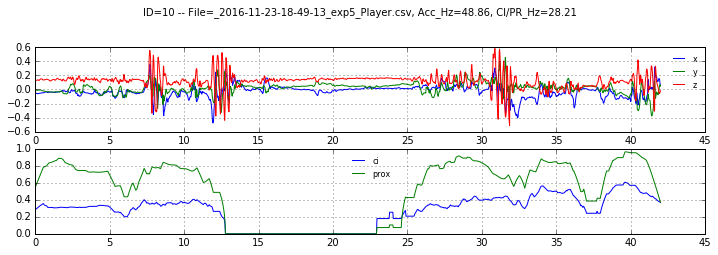

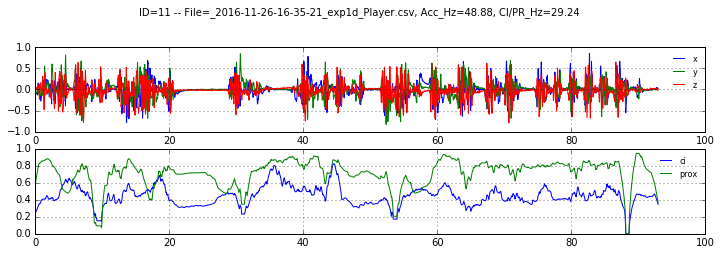

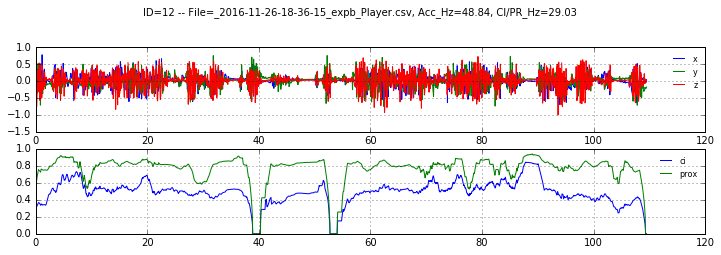

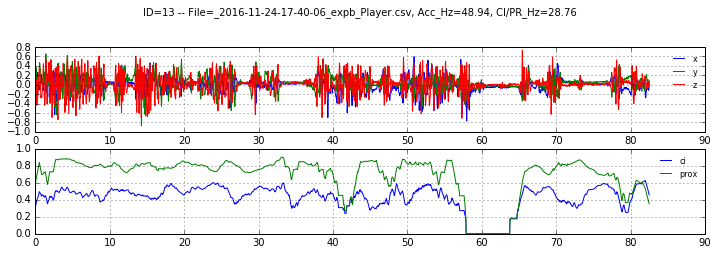

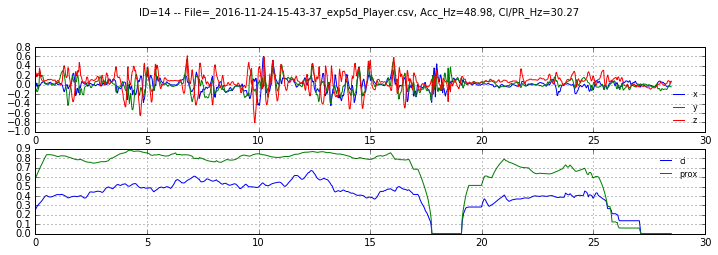

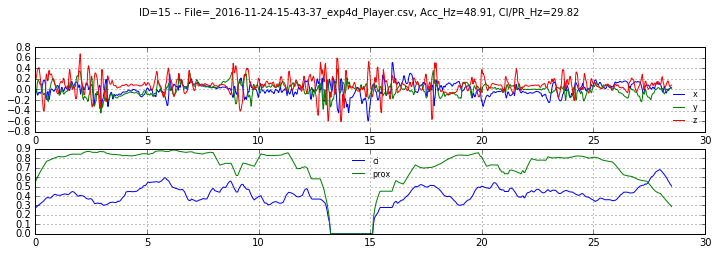

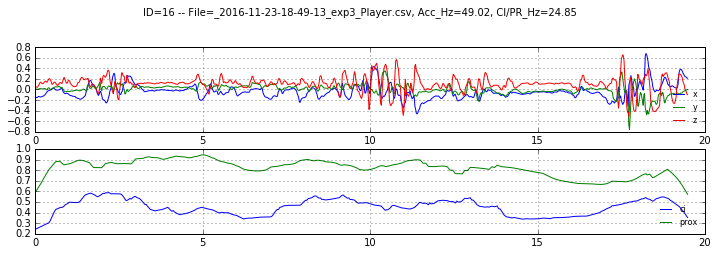

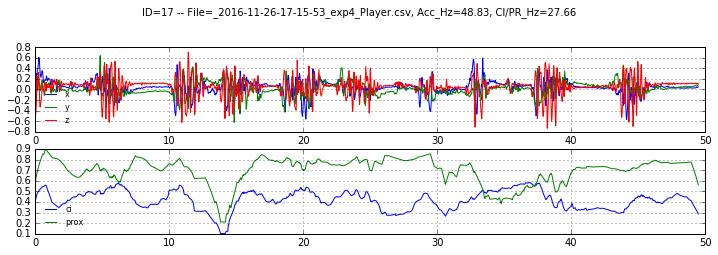

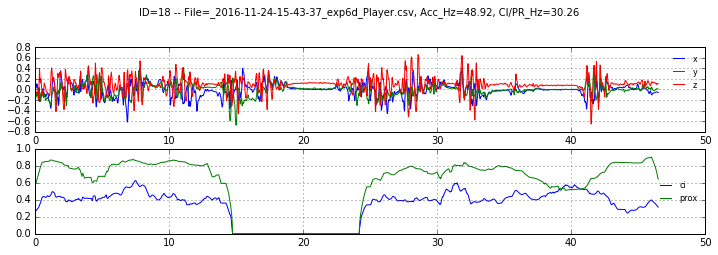

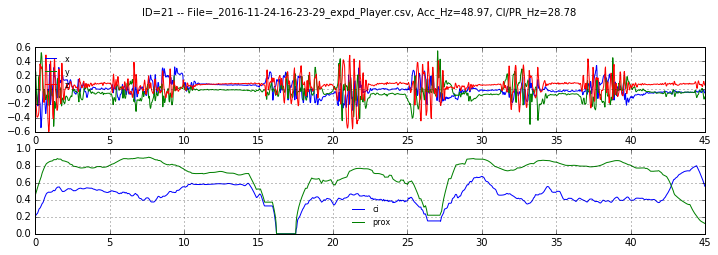

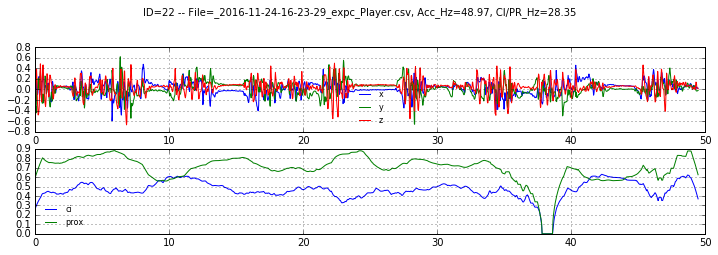

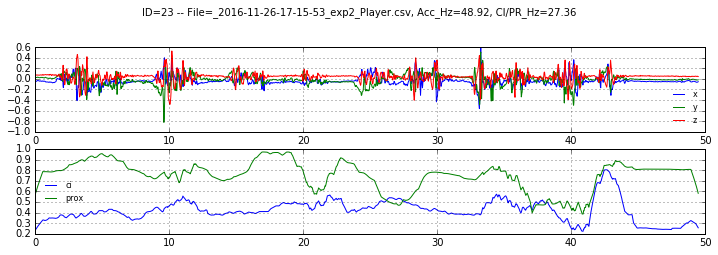

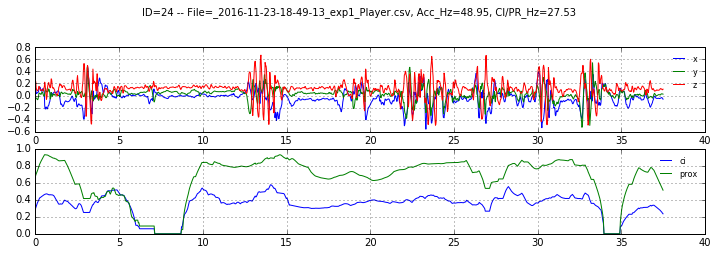

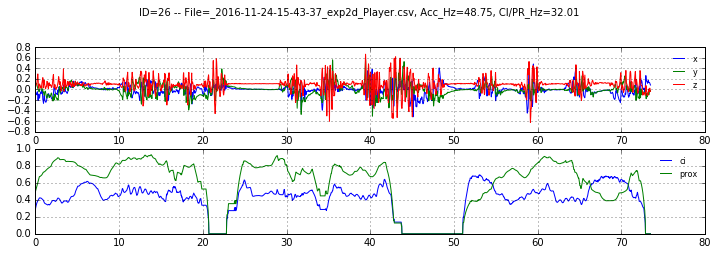

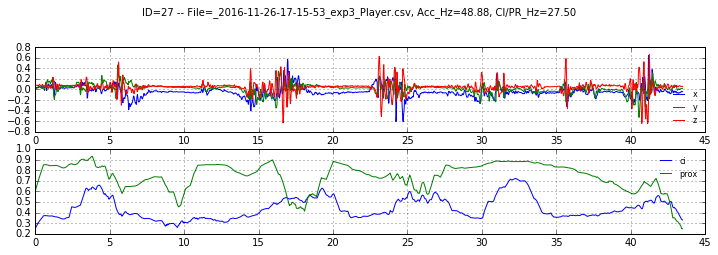

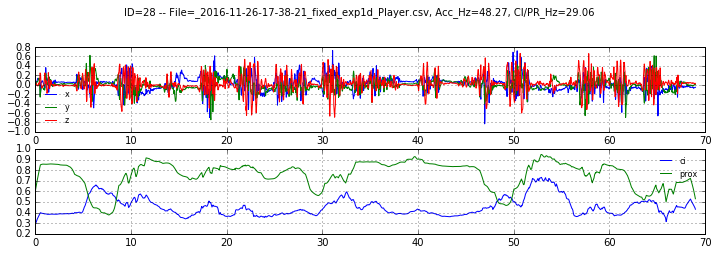

In [13]:
# Because accelerometer and kinect data (ci and proximity) have different frequency, we get them separatedly by
# using the getSegments data_type parameter.

x_segment_list, y_segment_list, z_segment_list, ci_segment_list, pr_segment_list = getSegments(arm_df, windows_size=win_size, data_type='acc')

## Plotting Segments && Associated Gramian Angular Field

In [14]:
def getGASF(series):
    '''Get all GASF from a <list> of segments.'''
    l = []
    for s in series:
        img, _ = serie2GAF.serie2GAF(list(s), GAF_type = 'GASF', rescale_type = 'Zero')
        l.append(img)
    return l

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


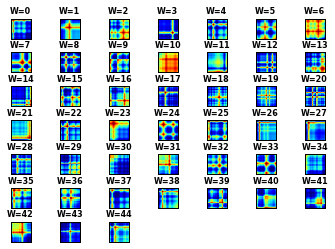

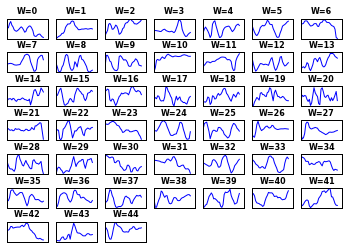

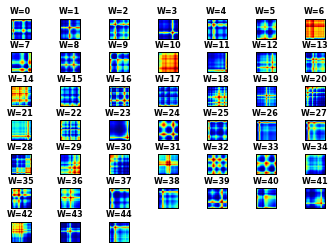

In [15]:
import scipy
import itertools

data_sources = {'x': x_segment_list,
                'y': y_segment_list,
                'z': z_segment_list,
                'ci': ci_segment_list,
                'pr': pr_segment_list}

### GET GASFs FOR ALL DATA_SOURCES
all_gasfs = {}
for src in data_sources.keys():
    gasfs = []
    for seg in data_sources[src]:
        gasfs.append(getGASF(seg))
    all_gasfs[src+"_gasf_list"] = gasfs
    all_gasfs[src+"_all_files_gasfs"] = list(itertools.chain.from_iterable(gasfs))
    
all_gasfs['files'] = [f[1] for f in datasetX]
######################################

### GET GASFs FOR linear combination of axis in the accelerometer
all_acc_gasfs={}
all_acc_gasfs['data'] = []
all_acc_gasfs['Lcombination'] = []
for i in range(len(x_segment_list)):
    gasfs = []
    combs = []
    for x, y, z in zip(x_segment_list[i],y_segment_list[i],z_segment_list[i]):
        comb = 0.25*np.array(x)+0.25*np.array(y)+0.5*np.array(z)
        gasfs.append(getGASF([comb])[0])
        combs.append(comb)
    all_acc_gasfs['data'].append(gasfs)
    all_acc_gasfs['Lcombination'].append(combs)
all_acc_gasfs['files'] = [f[1] for f in datasetX]
all_gasfs["all"] = list(itertools.chain.from_iterable(all_acc_gasfs['data']))
###################
    
# EXAMPLE
FILE = 4                  # which file to look
DATA = z_segment_list     # which data

#t = []
#for x, y, z in zip(getGASF(x_segment_list[FILE]),getGASF(y_segment_list[FILE]),getGASF(z_segment_list[FILE])):
#    t.append(0.25*x+0.25*y+0.5*z)

gridGAFPlotting(all_acc_gasfs['data'][FILE])

new_segs = [0.25*np.array(x)+0.25*np.array(y)+0.5*np.array(z) for x,y,z in zip(x_segment_list[FILE],
                                                                               y_segment_list[FILE],
                                                                               z_segment_list[FILE])]
gridPlotting(new_segs, set_axis_off=True)

gridGAFPlotting(getGASF(DATA[FILE]))

## Exporting all GAF data

In [18]:
import pickle

print "#Games: {}".format(len(ci_segment_list))

DATA = z_segment_list

ALL_GAF = []

for i in range(len(DATA)):
    for s in DATA[i]:
        rescaled_sample = serie2GAF.rescale(list(s))
        img, _ = serie2GAF.serie2GAF(rescaled_sample)
        #img_resized = scipy.misc.imresize(img, (28,28), interp='nearest')  # subsampling for 28x28
        #images.append(img_resized)
        ALL_GAF.append(img)

#print np.array(images).shape
# write python dict to a file
#output = open('all_ci_game_28x28.pkl', 'wb')
#pickle.dump(np.array(images), output)
#output.close()

#Games: 26


## Latent Dirichlet Allocation

In [19]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from time import time

In [20]:
print "OpenCV version: {}".format(cv2.__version__)

OpenCV version: 3.2.0-dev


## Data preparation

In [21]:
N_FILES_USED_FOR_TRAINNING = 23

## getting training files segments
n_train_segments = sum([len(DATA[i]) for i in range(len(DATA[:N_FILES_USED_FOR_TRAINNING]))])
print "# Train segments: {}".format(n_train_segments)

data_train = ALL_GAF[:n_train_segments]
data_test = ALL_GAF[n_train_segments:]

data_train = np.array(data_train).reshape(len(data_train), -1)
data_test = np.array(data_test).reshape(len(data_test), -1)

print "Train data shape: {}".format(data_train.shape)
print "Test data shape: {}".format(data_test.shape)

num_test_images = len(data_test)
num_train_images = len(data_train)

# Train segments: 355
Train data shape: (355, 22500)
Test data shape: (59, 22500)


## SIFT, Cluster dictionary, PCA

Stacked descriptions: (151809, 128)
K-means objective: 12830455870.66
elapsed time: 5.6774 sec


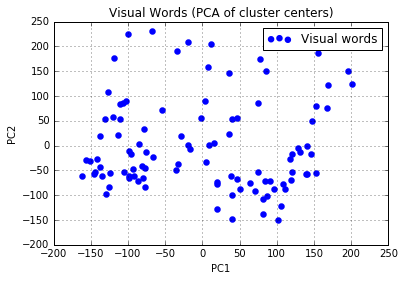

In [22]:
# Compute dense SIFT
num_kps = np.zeros(num_train_images)
sift = cv2.xfeatures2d.SIFT_create()


for img_idx in range(num_train_images):

    if not np.max(data_train[img_idx, :]):
        gray_img = data_train[img_idx, :]
    else:
        gray_img = 255*data_train[img_idx, :]/np.max(data_train[img_idx, :])          # scale
    
    gray_img = gray_img.reshape(win_size, win_size).astype(np.uint8)      # reshape and cast
    
    kp = sift.detect(gray_img,None)
    kp, des = sift.compute(gray_img, kp)
    # kp, des = orb.compute(gray_img, kp)
    # img_kp = cv2.drawKeypoints(gray_img, kp, color=(0,255,0), flags=0)
    # cv2.imshow('ORB keypoints', img_kp)

    num_kps[img_idx] = len(kp)
    
    # Stack descriptors for all training images
    if img_idx == 0:
        des_tot = des
    else:
        if des is None:
            des = np.ones((1,128)) * -1
        des_tot = np.vstack((des_tot, des))

print "Stacked descriptions: {}".format(des_tot.shape)

# Cluster images into a dictionary
dictionary_size = 100

kmeans = MiniBatchKMeans(n_clusters=dictionary_size,
                         init='k-means++',
                         batch_size=5000,
                         random_state=0,
                         verbose=0)
tic = time()
kmeans.fit(des_tot)
toc = time()
kmeans.get_params()

print "K-means objective: %.2f" % kmeans.inertia_
print "elapsed time: %.4f sec" % (toc - tic)

# PCA plot of kmeans_cluster centers
pca = PCA(n_components=2)
visual_words = pca.fit_transform(kmeans.cluster_centers_)

plt.figure()
plt.scatter(visual_words[:, 0], visual_words[:, 1], color='b', marker='o', lw=2.0, label='Visual words')
plt.title("Visual Words (PCA of cluster centers)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()
plt.show()

### Histogram of labels for each image = term-document matrix

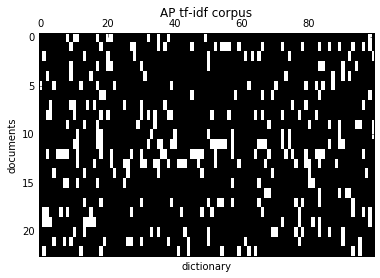

In [23]:
doc_words = []

for s in des_tot:
    doc_words.append(list(kmeans.predict(s.reshape(1, -1)))[0])

## Getting segments per documents back.
n_segments_per_doc = [len(DATA[i]) for i in range(len(DATA[:N_FILES_USED_FOR_TRAINNING]))]

docs = []

index = 0
for i, n_seg in enumerate(n_segments_per_doc):
    docs.append(doc_words[index:index+n_seg])
    index += n_seg
    assert len(docs[i]) == n_seg    

num_train_games = len(docs)

A = np.zeros((dictionary_size, num_train_games))
ii = 0
jj = 0
#labels = kmeans.labels_

for doc_idx in range(num_train_games):
    A[:, doc_idx], bins = np.histogram(docs[doc_idx], bins=range(dictionary_size+1))

plt.spy(A.T, cmap="gray")
plt.gca().set_aspect('auto')
plt.title('AP tf-idf corpus')
plt.xlabel('dictionary')
plt.ylabel('documents')    
plt.show()

## Fit LDA topic model based on tf-idf of term-document matrix

Fitting LDA model...
Elapsed time: 0.3819 sec
LDA params
{
    "learning_offset": 10.0, 
    "n_jobs": 1, 
    "topic_word_prior": null, 
    "perp_tol": 0.1, 
    "evaluate_every": -1, 
    "max_iter": 50, 
    "mean_change_tol": 0.001, 
    "batch_size": 128, 
    "max_doc_update_iter": 100, 
    "learning_decay": 0.7, 
    "random_state": 0, 
    "doc_topic_prior": null, 
    "n_topics": 5, 
    "total_samples": 1000000.0, 
    "learning_method": "batch", 
    "verbose": 0
}
Number of EM iter: 51
Number of dataset sweeps: 50


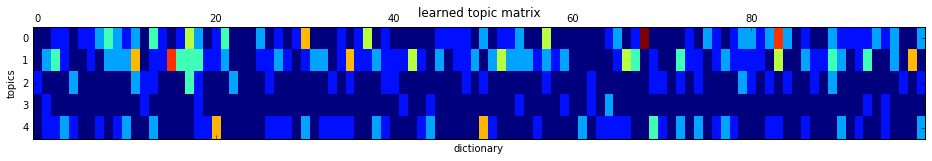

In [24]:
num_features = dictionary_size
num_topics = 5      # fixed for LDA

# Fit LDA model
print "Fitting LDA model..."
lda_vb = LatentDirichletAllocation(n_topics=num_topics,
                                   max_iter=50,
                                   learning_method='batch',
                                   random_state=0,
                                   n_jobs=1)

tic = time()
lda_vb.fit(A.T)         # online VB
toc = time()

print "Elapsed time: %.4f sec" % (toc - tic)
print "LDA params"
print json.dumps(lda_vb.get_params(), indent=4)

print "Number of EM iter: %d" % lda_vb.n_batch_iter_
print "Number of dataset sweeps: %d" % lda_vb.n_iter_

# topic matrix W: K x V
# components[i,j]: topic i, word j
# note: here topics correspond to label clusters
topics = lda_vb.components_

plt.matshow(topics, cmap=plt.get_cmap("jet"))
plt.gca().set_aspect('auto')
plt.title('learned topic matrix')
plt.ylabel('topics')
plt.xlabel('dictionary')
plt.show()

### Topic proportions matrix: D x K

NOTE: np.sum(H, axis=1) is not 1

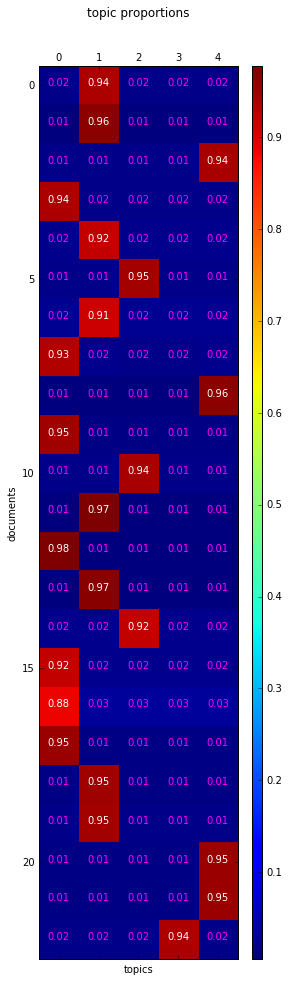

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

H = lda_vb.transform(A.T)

plot_colormap(H)

## Test data

In [ ]:
# Given test data transform test image into tf_idf vector
# Show mean test image
plt.imshow(np.mean(data_test, axis=0).reshape(50, 50))
plt.show()

In [ ]:
num_test_images = data_test.shape[0]
num_test_kps = np.zeros(num_test_images)

# Compute dense SIFT
sift = cv2.xfeatures2d.SIFT_create()
# orb = cv2.ORB()

for img_idx in range(num_test_images):
    # Extractin features
    if not np.max(data_test[img_idx, :]):
        gray_img = data_test[img_idx, :]
    else:
        gray_img = 255*data_test[img_idx, :]/np.max(data_test[img_idx, :])          # scale
        
    gray_img = gray_img.reshape(windows_size, windows_size).astype(np.uint8)                  # reshape and cast

    # dense = cv2.FeatureDetector_create("Dense")
    # kp = dense.detect(gray_img)
    kp = sift.detect(gray_img, None)
    kp, des = sift.compute(gray_img, kp)
    # kp, des = orb.compute(gray_img, kp)
    # img_kp = cv2.drawKeypoints(gray_img, kp, color=(0,255,0), flags=0)
    # cv2.imshow('ORB keypoints', img_kp)

    num_test_kps[img_idx] = len(kp)
    
    # Stack descriptors for all test images
    if img_idx == 0:
        des_test_tot = des
    else:
        if des is None:
            des = np.ones((1,128)) * -1
        des_test_tot = np.vstack((des_test_tot, des))

In [ ]:
test_doc_words = []

for s in des_test_tot:
    test_doc_words.append(list(kmeans.predict(s.reshape(1, -1)))[0])

## Getting segments per documents back.
n_segments_per_test_doc = [len(DATA[i]) for i in range(len(DATA[N_FILES_USED_FOR_TRAINNING:]))]

test_docs = []

index = 0
for i, n_seg in enumerate(n_segments_per_test_doc):
    test_docs.append(test_doc_words[index:index+n_seg])
    index += n_seg
    assert len(test_docs[i]) == n_seg

num_test_games = len(test_docs)

In [ ]:
# Assign des_test_tot to one of kmeans cluster centers
# Use 128-dimensional kd-tree to search for nearest neighbors
kdt = KDTree(kmeans.cluster_centers_)

Q = des_test_tot                        # query
kdt_dist, kdt_idx = kdt.query(Q, k=1)   # knn
test_labels = kdt_idx                   # knn = 1 labels

# Form A_test matrix from test_labels
# Histogram of labels for each image: term-document matrix
A_test = np.zeros((dictionary_size, num_test_games))
for doc_idx in range(num_test_games):
    A_test[:, doc_idx], bins = np.histogram(test_docs[doc_idx], bins=range(dictionary_size+1))

plt.spy(A_test.T, cmap="gray")
plt.gca().set_aspect('auto')
plt.title('AP tf-idf corpus')
plt.xlabel('dictionary')
plt.ylabel('documents')
plt.show()                 

# Use fit transform on A_test for already trained LDA to get the H_test matrix
# topic proportions matrix: D x K
# note: np.sum(H, axis=1) is not 1
H_test = lda_vb.transform(A_test.T)    

plot_colormap(H_test)

# plt.savefig('./figures/proportions_test.png')

# Retrieve H_train document that's closest in cosine similarity for each H_test
# Use cosine similarity for image retrieval
Kxy = cosine_similarity(H_test, H)
knn_test = np.argmin(Kxy, axis=1)      

plot_colormap(Kxy, title='Cosine Similarity', xlabel='train data', ylabel='test data')
# plt.savefig('./figures/cosine_similarity.png')

# Display knn images (docId is an image)
rnd_idx = np.arange(num_test_images)
np.random.shuffle(rnd_idx)
images = data_test[rnd_idx[0:16], :].reshape(16, windows_size, windows_size)
plot_images(4, 4, images)
images_knn = data_train[knn_test[rnd_idx[0:16]], :].reshape(16, windows_size, windows_size)
plot_images(4, 4, images_knn)

In [ ]:
#gridPlotting(docs[3])#, ALL_GAF[n_train_segments:][0]])
plt.plot(list(itertools.chain.from_iterable(ci_segment_list[0])))
plt.show()
plt.plot(list(itertools.chain.from_iterable(ci_segment_list[26])))
plt.show()
plt.plot(list(itertools.chain.from_iterable(ci_segment_list[5])))
plt.show()
plt.plot(list(itertools.chain.from_iterable(ci_segment_list[6])))
plt.show()

In [ ]:
150 * (1/48.8)